In [1]:
from catalogue import *

Using TensorFlow backend.


In [2]:
inputs, outputs, error, df_original = load_data()
print "Number of stars:", inputs.shape[0]
print "Shape of inputs, outputs, and error from loading data..."
print inputs.shape, outputs.shape, error.shape

inputs['u-g'] = inputs['u'].subtract(inputs['g'])
inputs['u-i'] = inputs['u'].subtract(inputs['i'])
inputs['g-r'] = inputs['g'].subtract(inputs['r'])
inputs['g-z'] = inputs['g'].subtract(inputs['z'])

m = 0.42 # u - g
b = 0.3 # g - r

# Apply a color cut to remove the contaminent stars (i.e. that are not giants or dwarfs)
colour_cut_a = (m*inputs['u-g'] - b > inputs['g-r'])
colour_cut_b = (m*inputs['u-g'] - b <= inputs['g-r'])

a_star=inputs[colour_cut_a]
outputs=outputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
error=error[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
inputs=inputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 

# Apply the color cuts for machine learning 
ui_thres = 1.3
gz_thres = 0.05

# Select only the lowest error in logg
logg_error_thres = 0.16

ml_cut =  (inputs['u-i'] >= ui_thres) & (inputs['u-i'] <= 2.6) & (inputs['g-z'] >= gz_thres)

input_forML2 = inputs[ml_cut]
output_forML2 = outputs[ml_cut]
error_forML2 = error[ml_cut]

logg_cut = (error_forML2['dlogg'] <= logg_error_thres)

input_finalML2 = input_forML2[logg_cut].reset_index(drop=True)
output_finalML2 = output_forML2[logg_cut].reset_index(drop=True)
error_finalML2 = error_forML2[logg_cut].reset_index(drop=True)

# For binary classification, we need to set the threshold for which
# logg we decide is a dwarf or a giant
output_finalML2['logg_binary'] = np.where(output_finalML2['logg'] > 3.5, 'dwarf', 'giant')

print "Number of stars after machine learning cuts in u-i, and g-z:", input_finalML2.shape[0]

/opt/conda/lib/python2.7/site-packages/pandas/core/frame.py:5085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


Number of stars: 142750
Shape of inputs, outputs, and error from loading data...
(142750, 9) (142750, 3) (142750, 3)
Number of stars after machine learning cuts in u-i, and g-z: 76724


In [3]:
seed = 7
epochs=50
batch_size =1000

np.random.seed(seed)

inputf = normalize(input_finalML2)
outputf = normalize(output_finalML2)
errorf = normalize(error_finalML2, 'min_max')

# Make data to train on colours
inputs_col = pd.DataFrame()
#u-g,g-r,r-i,i-z
inputs_col['u-g']=inputf['u']-inputf['g']
inputs_col['g-r']=inputf['g']-inputf['r']
inputs_col['r-i']=inputf['r']-inputf['i']
inputs_col['i-z']=inputf['i']-inputf['z']
inputs_col['z-y']=inputf['z']-inputf['y']
inputs_col['u-G']=inputf['u']-inputf['G']
inputs_col['u-RP']=inputf['u']-inputf['RP']
inputs_col['u-BP']=inputf['u']-inputf['BP']

X = inputs_col.values.astype(float)

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=8, kernel_initializer='normal', activation='relu')) #input_dim=13,
    model.add(Dense(5096, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(outputf['logg_binary'])
encoded_Y = encoder.transform(outputf['logg_binary'])

new_model = True

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
estimator = KerasClassifier(build_fn=create_baseline, epochs=epochs, batch_size=batch_size, verbose=1)

if new_model:
    # evaluate model with standardized dataset
    print "Baseline creation..."
    y_pred = cross_val_predict(estimator, X, encoded_Y, cv=kfold, n_jobs = 3)
    y_val = (y_pred, encoded_Y)
    pickle.dump(y_val, open( "./pickle/binary_class_pred.pickle", "wb" ) )

else:
    y_val = pickle.load(open( "./pickle/binary_class_pred.pickle", "rb" ))
    
    
conf_mat = confusion_matrix(encoded_Y, y_pred)
y_true = pd.Series(outputf['logg_binary'])
y_predicted = encoder.inverse_transform(y_pred[:,0])
y_prd = pd.Series(y_predicted)

display(pd.crosstab(y_true, y_prd, rownames=['True'], colnames=['Predicted'], margins=True))
#cm = confusion_matrix(y_true, y_prd)
cm = conf_mat

tp0, fn, fp, tp1 = map(float, cm.ravel())

tp = tp0+tp1
precision = tp/(tp+fp)
accuracy = (tp0+tp1)/ (tp0+tp1+fn+fp)
recall = tp/(tp+fn)
recall_1 = tp0/(tp0+fn)
recall_2 = tp1/(tp1+fn)
F1 = 2*(recall * precision) / (recall + precision)
completeness = tp0/(tp0+fp)
purity = tp1/(tp1+fp)
print "Accuracy:", accuracy
print "Precision:", precision
print "Recall:",recall, recall_1, recall_2
print "F1:", F1
print "Completeness:", completeness
print "Purity:", purity

estimator.fit(X, encoded_Y, epochs=50, batch_size=1000, verbose=1)

Baseline creation...
Epoch 1/50
Epoch 1/50
Epoch 1/50
51149/51149 [==============================] - 5s 100us/step - loss: 0.4979 - acc: 0.7974
Epoch 2/50
51150/51150 [==============================] - 5s 99us/step - loss: 0.4993 - acc: 0.7964
Epoch 2/50
51149/51149 [==============================] - 5s 100us/step - loss: 0.4994 - acc: 0.7967
Epoch 2/50
51149/51149 [==============================] - 4s 86us/step - loss: 0.3309 - acc: 0.8540
Epoch 3/50
51149/51149 [==============================] - 4s 87us/step - loss: 0.3313 - acc: 0.8553
Epoch 3/50
51149/51149 [==============================] - 5s 89us/step - loss: 0.3047 - acc: 0.8694
Epoch 4/50
51149/51149 [==============================] - 5s 90us/step - loss: 0.3012 - acc: 0.8729
Epoch 4/50
51150/51150 [==============================] - 5s 91us/step - loss: 0.3009 - acc: 0.8727
Epoch 4/50
51149/51149 [==============================] - 5s 91us/step - loss: 0.2912 - acc: 0.8754
Epoch 5/50
Epoch 5/50
51150/51150 [====================

Epoch 26/50
51150/51150 [==============================] - 4s 86us/step - loss: 0.2457 - acc: 0.8960
Epoch 26/50
51149/51149 [==============================] - 4s 80us/step - loss: 0.2471 - acc: 0.8950
Epoch 27/50
51149/51149 [==============================] - 4s 84us/step - loss: 0.2439 - acc: 0.8957
Epoch 27/50
51150/51150 [==============================] - 4s 84us/step - loss: 0.2471 - acc: 0.8950
Epoch 27/50
51149/51149 [==============================] - 4s 81us/step - loss: 0.2437 - acc: 0.8963
Epoch 28/50
51149/51149 [==============================] - 4s 81us/step - loss: 0.2479 - acc: 0.8940
Epoch 28/50
51150/51150 [==============================] - 4s 81us/step - loss: 0.2474 - acc: 0.8946
Epoch 28/50
51149/51149 [==============================] - 4s 83us/step - loss: 0.2426 - acc: 0.8974
Epoch 29/50
51149/51149 [==============================] - 4s 83us/step - loss: 0.2442 - acc: 0.8957
Epoch 29/50
51150/51150 [==============================] - 4s 84us/step - loss: 0.2411 - ac

51149/51149 [==============================] - 4s 84us/step - loss: 0.1849 - acc: 0.9241
Epoch 50/50
51150/51150 [==============================] - 4s 83us/step - loss: 0.1902 - acc: 0.9211
Epoch 50/50
25574/25574 [==============================] - 0s 19us/step


/opt/conda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted,dwarf,giant,All
True,,,
dwarf,59601,2136,61737
giant,4245,10742,14987
All,63846,12878,76724


Accuracy: 0.916831760596
Precision: 0.943087359897
Recall: 0.970529394721 0.965401623014 0.834135735363
F1: 0.956611612394
Completeness: 0.93351188798
Purity: 0.716754520585
Epoch 1/50
76724/76724 [==============================] - 3s 42us/step - loss: 0.4478 - acc: 0.8139
Epoch 2/50
76724/76724 [==============================] - 3s 33us/step - loss: 0.3067 - acc: 0.8707
Epoch 3/50
76724/76724 [==============================] - 3s 35us/step - loss: 0.2886 - acc: 0.8759
Epoch 4/50
76724/76724 [==============================] - 2s 32us/step - loss: 0.2799 - acc: 0.8787
Epoch 5/50
76724/76724 [==============================] - 2s 33us/step - loss: 0.2758 - acc: 0.8812
Epoch 6/50
76724/76724 [==============================] - 3s 34us/step - loss: 0.2733 - acc: 0.8815
Epoch 7/50
76724/76724 [==============================] - 3s 33us/step - loss: 0.2690 - acc: 0.8847
Epoch 8/50
76724/76724 [==============================] - 3s 34us/step - loss: 0.2667 - acc: 0.8857
Epoch 9/50
76724/76724 [==

In [6]:
def change_to_colour(inputf):
    # Make data to train on colours
    inputs_col = pd.DataFrame()
    inputf = normalize(inputf)
    inputs_col['u-g']=inputf['u']-inputf['g']
    inputs_col['g-r']=inputf['g']-inputf['r']
    inputs_col['r-i']=inputf['r']-inputf['i']
    inputs_col['i-z']=inputf['i']-inputf['z']
    inputs_col['z-y']=inputf['z']-inputf['y']
    inputs_col['u-G']=inputf['u']-inputf['G']
    inputs_col['u-RP']=inputf['u']-inputf['RP']
    inputs_col['u-BP']=inputf['u']-inputf['BP']
    return inputs_col

# keras library import  for Saving and loading model and weights
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = estimator.model.to_json()

with open("./models/2nd_col/model_num_3rd_A_col.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
estimator.model.save_weights("./models/2nd_col/model_num_3rd_A_col.h5")
 
# load json and create model
json_file = open('./models/2nd_col/model_num_3rd_A_col.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./models/2nd_col/model_num_3rd_A_col.h5")
print("Loaded model from disk")
 
def criteria_function(inputs_NGC, std_x, col_1, col_2):
    ra_cut = (inputs_NGC['pmra']>(inputs_NGC['pmra'].mean()-std_x*(inputs_NGC['pmra'].std()))) & (inputs_NGC['pmra']<(inputs_NGC['pmra'].mean()+std_x*(inputs_NGC['pmra'].std())))
    dec_cut = (inputs_NGC['pmdec']>(inputs_NGC['pmdec'].mean()-std_x*(inputs_NGC['pmdec'].std()))) & (inputs_NGC['pmdec']<(inputs_NGC['pmdec'].mean()+std_x*(inputs_NGC['pmdec'].std()))) 
    # Apply the color cuts for machine learning 
    ui_thres = 1.3
    gz_thres = 0.05
    ml_cut =  (inputs_NGC['u']-inputs_NGC['i'] >= ui_thres) & (inputs_NGC['u']-inputs_NGC['i'] <= 2.6) & (inputs_NGC['g']-inputs_NGC['z'] >= gz_thres)
    criteria = ra_cut & dec_cut & (inputs_NGC['u']-inputs_NGC['G'] < col_1) & (inputs_NGC['u']-inputs_NGC['G'] > col_2)
    return criteria

Loaded model from disk


4562
2063


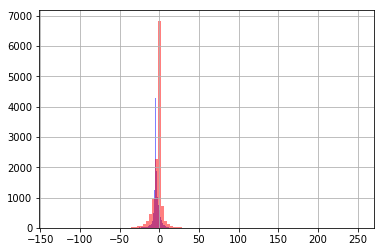

In [7]:
inputs_NGC6341 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6341.fits')
inputs_NGC6205 = load_data_glob('./data/CFIS_PSf_Gaia_NGC6205.fits')
inputs_NGC5466 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5466.fits')
inputs_NGC5272 = load_data_glob('./data/CFIS_PSf_Gaia_NGC5272.fits')

inputs_NGC6341['pmra'].std()

inputs_NGC6341['pmra'].hist(alpha=0.5, color='blue', bins=100)
inputs_NGC6341['pmdec'].hist(alpha=0.5, color='red', bins=100)
std_x  = 0.3

# load weights into new model
json_file = open('./models/2nd_col/model_num_3rd_A_col.json', 'r')
loaded_model_json = json_file.read()

json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./models/2nd_col/model_num_3rd_A_col.h5")
loaded_model.load_weights("./models/2nd_col/model_num_3rd_A_col.h5")

##############################
## NGC 6341 ##
##############################
criteria = criteria_function(inputs_NGC6341, std_x, 2.5, 0)
inputs_NGC6341 = inputs_NGC6341[criteria]
inputs_NGC6341_b = change_to_colour(inputs_NGC6341)
inputs_NGC6341['class'] =  loaded_model.predict_classes(inputs_NGC6341_b.values)
    
##############################
## NGC 6205 ##
##############################
criteria = criteria_function(inputs_NGC6205, std_x, 2.5, 0)
inputs_NGC6205 = inputs_NGC6205[criteria]
inputs_NGC6205_b = change_to_colour(inputs_NGC6205)
inputs_NGC6205['class'] =  loaded_model.predict_classes(inputs_NGC6205_b.values)

##############################
## NGC 5466 ##
##############################
criteria = criteria_function(inputs_NGC5466, std_x, 2.5, 0)
inputs_NGC5466 = inputs_NGC5466[criteria]
inputs_NGC5466_b = change_to_colour(inputs_NGC5466)
inputs_NGC5466['class'] =  loaded_model.predict_classes(inputs_NGC5466_b.values)

##############################
## NGC 5272 ##
##############################
criteria = criteria_function(inputs_NGC5272, std_x, 2.5, 0)
inputs_NGC5272 = inputs_NGC5272[criteria]
inputs_NGC5272_b = change_to_colour(inputs_NGC5272)
inputs_NGC5272['class'] =  loaded_model.predict_classes(inputs_NGC5272_b.values)

inputs_NGC6341_giants = inputs_NGC6341[(inputs_NGC6341['class']==1)]
inputs_NGC6341_dwarfs = inputs_NGC6341[(inputs_NGC6341['class']==0)]

inputs_NGC6205_giants = inputs_NGC6205[(inputs_NGC6205['class']==1)]
inputs_NGC6205_dwarfs = inputs_NGC6205[(inputs_NGC6205['class']==0)]

inputs_NGC5466_giants = inputs_NGC5466[(inputs_NGC5466['class']==1)]
inputs_NGC5466_dwarfs = inputs_NGC5466[(inputs_NGC5466['class']==0)]

inputs_NGC5272_giants = inputs_NGC5272[(inputs_NGC5272['class']==1)]
inputs_NGC5272_dwarfs = inputs_NGC5272[(inputs_NGC5272['class']==0)]

print inputs_NGC6341.shape[0]
print inputs_NGC6341_giants.shape[0]

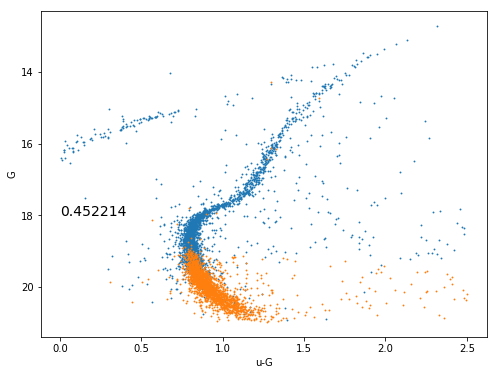

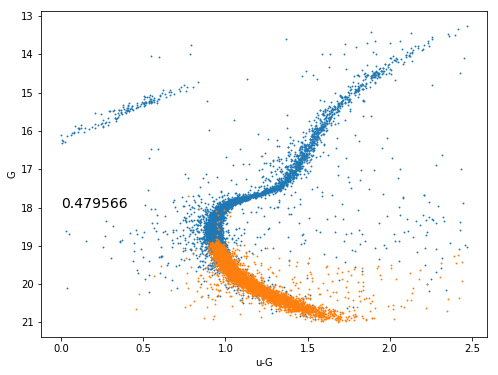

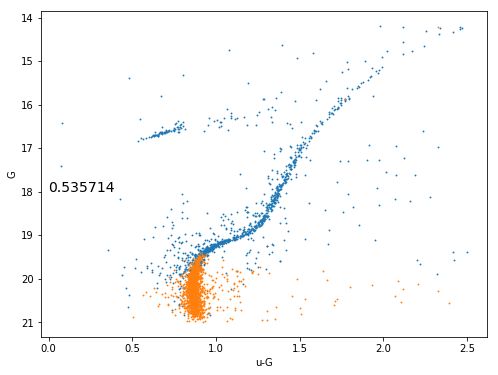

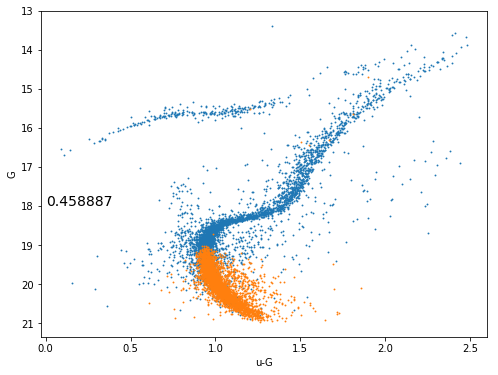

In [8]:
fig =plt.figure(figsize=(8,6))
plt.xlabel('u-G')
plt.ylabel('G')
plt.scatter((inputs_NGC6341_dwarfs['u']-inputs_NGC6341_dwarfs['G']).values, inputs_NGC6341_dwarfs['G'].values, s=0.75)
plt.scatter((inputs_NGC6341_giants['u']-inputs_NGC6341_giants['G']).values, inputs_NGC6341_giants['G'].values, s=0.75)#, rasterized=True, c=inputs_NGC5272['class'], cmap=plt.cm.RdBu)
plt.gca().invert_yaxis()
plt.annotate(r"%f"%(float(inputs_NGC6341_giants.shape[0])/inputs_NGC6341.shape[0]), xy=(0,18.0), color='black',size=14)
plt.savefig('./plots/1st_col/NGC6341_1st_col')

fig =plt.figure(figsize=(8,6))
plt.xlabel('u-G')
plt.ylabel('G')
plt.scatter((inputs_NGC6205_dwarfs['u']-inputs_NGC6205_dwarfs['G']).values, inputs_NGC6205_dwarfs['G'].values, s=0.75)
plt.scatter((inputs_NGC6205_giants['u']-inputs_NGC6205_giants['G']).values, inputs_NGC6205_giants['G'].values, s=0.75)#, rasterized=True, c=inputs_NGC5272['class'], cmap=plt.cm.RdBu)
plt.gca().invert_yaxis()
plt.annotate(r"%f"%(float(inputs_NGC6205_giants.shape[0])/inputs_NGC6205.shape[0]), xy=(0,18.0), color='black',size=14)
plt.savefig('./plots/1st_col/NGC6205_1st_col')

fig =plt.figure(figsize=(8,6))
plt.xlabel('u-G')
plt.ylabel('G')
plt.scatter((inputs_NGC5466_dwarfs['u']-inputs_NGC5466_dwarfs['G']).values, inputs_NGC5466_dwarfs['G'].values, s=0.75)
plt.scatter((inputs_NGC5466_giants['u']-inputs_NGC5466_giants['G']).values, inputs_NGC5466_giants['G'].values, s=0.75)#, rasterized=True, c=inputs_NGC5272['class'], cmap=plt.cm.RdBu)
plt.gca().invert_yaxis()
plt.annotate(r"%f"%(float(inputs_NGC5466_giants.shape[0])/inputs_NGC5466.shape[0]), xy=(0,18.0), color='black',size=14)
plt.savefig('./plots/1st_col/NGC5466_1st_col')


fig =plt.figure(figsize=(8,6))
plt.xlabel('u-G')
plt.ylabel('G')
plt.scatter((inputs_NGC5272_dwarfs['u']-inputs_NGC5272_dwarfs['G']).values, inputs_NGC5272_dwarfs['G'].values, s=0.75)
plt.scatter((inputs_NGC5272_giants['u']-inputs_NGC5272_giants['G']).values, inputs_NGC5272_giants['G'].values, s=0.75)#, rasterized=True, c=inputs_NGC5272['class'], cmap=plt.cm.RdBu)
plt.gca().invert_yaxis()
plt.annotate(r"%f"%(float(inputs_NGC5272_giants.shape[0])/inputs_NGC5272.shape[0]), xy=(0,18.0), color='black',size=14)
plt.savefig('./plots/1st_col/NGC5272_1st_col')